In [1]:
import pandas as pd
import json
import psycopg2
import os
import sys
import time
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 100000
import warnings
warnings.filterwarnings("ignore")

In [2]:
import datatable as dt
import sidetable

In [9]:
!pip install sidetable

Defaulting to user installation because normal site-packages is not writeable


In [3]:
def print_labels_v(plot):
    '''  
    function prints labels on vertical plots
    '''
    for rect in plot.patches:
        xcoor = rect.get_x() + .5*rect.get_width();
        ycoor = rect.get_height();
        plt.text(xcoor, ycoor, str(round(ycoor, 2))+' %', 
                 horizontalalignment='center', 
                 verticalalignment='bottom',
                 fontsize=14);
    return plot;

def print_labels_h(plot):
    '''  
    function prints labels on horizontal plots
    '''
    for rect in plot.patches:
        ycoor = rect.get_y() + .5*rect.get_height();
        xcoor = rect.get_width();
        plt.text(xcoor, ycoor, str(int(xcoor)), 
                 horizontalalignment='left', 
                 verticalalignment='center',
                 fontsize=14);
    return plot;

# Downloads EDA

In [4]:
df = dt.fread("/project/class/sds_sdad/oss_capstone2021-2022/clean_data_11132021/pypi_downloads_365DAY_01012020.csv")

In [5]:
dwnld_df = df.to_pandas()
dwnld_df = dwnld_df.drop(columns=['C0'])

In [6]:
#dwnld_df = pd.read_csv('/project/class/sds_sdad/oss_capstone2021-2022/clean_data_11132021/pypi_downloads_365DAY_01012020.csv',low_memory=False, chunksize=50_000)

In [7]:
dwnld_df

,country_code,name,version,num_downloads
0,US,chardet,3.0.4,529606563
1,US,python-dateutil,2.8.1,506601529
2,US,six,1.15.0,425427437
3,US,pyasn1,0.4.8,423882729
4,US,s3transfer,0.3.3,413058876
...,...,...,...,...
85397262,AP,cadccutout,0.3.0,1
85397263,MX,emencia-django-forum,0.7.1,1
85397264,MX,ultimate,1.9.2,1
85397265,GE,z4-solver,2019.10.12.2,1


In [15]:
dwnld_gb = dwnld_df[['name','num_downloads']].groupby('name').sum()
dwnld_gb

,num_downloads
name,
0,11187
0-0-1,5541
0-1,2
0-core-client,23969
0-orchestrator,34232
...,...
zzzeeksphinx,7386
zzzfs,1521
zzzutils,2048


In [16]:
dwnld_gb = dwnld_gb.sort_values('num_downloads', ascending=False).reset_index()
dwnld_gb

,name,num_downloads
0,urllib3,1307838418
1,six,1148580936
2,botocore,1007087949
3,requests,952566053
4,setuptools,950167049
...,...,...
288658,khang-tran-spriteutil-python,1
288659,s3trannsfer,1
288660,s3tranfser,1
288661,dw-data-pipeline,1


In [40]:
#['cms-sw/cmssw','gem/oq-engine','matthiaskoenig/sbmlutils','glamp/bashplotlib','posborne/cmsis-svd', 'hover2pi/sedkit','algofairness/fairness-comparison','recognai/spacy-wordnet','tensorflow/datasets','mapsme/omim']
inf_slugs = ['jorgii/universal-api-client', 'liip/wrench','tmurph/todo-sync', 'oca/product-variant', 'caravelahc/libru', 'anoopkunchukuttan/indic_nlp_library',
            'oca/edi', 'n8henrie/fastcli', 'oca/account-payment', 'cameronlonsdale/torch', 's/xarray']


In [41]:
inf_slugs_short = [i.split('/')[1] for i in inf_slugs]
dwnld_gb[dwnld_gb.name.isin(inf_slugs_short)]

,name,num_downloads
440,torch,22383804
1277,xarray,3746671
57369,wrench,9451
85133,todo-sync,5723
102717,libru,4415
129022,edi,3118
150438,universal-api-client,2403
171827,fastcli,1881


In [29]:
sector = pd.read_csv('oss_2021_pypi_login_sectored.csv')

In [39]:
sector[sector.slug.isin(inf_slugs)]

,Unnamed: 0,slug,login,email,company,organization,location,country,is_us,is_null,is_academic,academic_frac,us_academic,frgn_academic,is_business,business_frac,us_business,frgn_business,is_gov,gov_frac,us_gov,frgn_gov,is_nonprofit,nonprofit_frac,us_nonprofit,frgn_nonprofit,is_household,household_frac,us_household,frgn_household,na_fraction,frgn_fraction,us_fraction
7349,7349,anoopkunchukuttan/indic_nlp_library,anoopkunchukuttan,anoop.kunchukuttan@gmail.com,iit bombay,Indian Institute of Technology Delhi,"Hyderabad, India | Mumbai, India",India,False,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
19223,19223,caravelahc/libru,caiopo,caiopoliveira@gmail.com,laboratoriobridge,Misc. Business,NaN,NaN,False,0.0,0.0,0.0,0.0,0.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,0.0,0.0,1.0,0.0,0.0
64803,64803,jorgii/universal-api-client,jorgii,NaN,mailjet,Misc. Business,NaN,NaN,False,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
73508,73508,liip/wrench,OdyX,odyx@debian.org,liip,Liip,"Vevey, Switzerland",Switzerland,False,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
73509,73509,liip/wrench,sephii,sylvain@fankhauser.name,NaN,NaN,Switzerland,Switzerland,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
73510,73510,liip/wrench,simonbru,simon@brulhart.me,NaN,NaN,NaN,NaN,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
87019,87019,n8henrie/fastcli,n8henrie,NaN,n8henrie,NaN,"Shiprock, NM",Mexico|United States,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5


# Old Stuff Below

In [8]:
cc = pd.read_csv('country_code.csv')

In [9]:
dwnld_df = dwnld_df.merge(cc,how='inner',left_on='country_code',right_on='Code').drop(columns=['country_code'])

In [10]:
dwnld_df = dwnld_df.sort_values(by='num_downloads',ascending=False)#.iloc[0:100,:]

In [11]:
dwnld_df.columns=['name','version','num_downloads','country_name','Code']

In [12]:
import plotly.express as px
'''
fig = px.choropleth(dwnld_df, locations='Code', 
                    hover_name='country_name',
                    title='Pypi Downloads 2020-2021',
                   width=1000, height=800)
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()
'''

"\nfig = px.choropleth(dwnld_df, locations='Code', \n                    hover_name='country_name',\n                    title='Pypi Downloads 2020-2021',\n                   width=1000, height=800)\nfig.update(layout=dict(title=dict(x=0.5)))\nfig.show()\n"

In [13]:
dwnld_df.describe() #look at summary statistics 

,num_downloads
count,8.124815e+07
mean,8.129657e+02
std,2.125103e+05
min,1.000000e+00
25%,2.000000e+00
50%,6.000000e+00
75%,2.000000e+01
max,5.296066e+08


### Top countries downloading pypi packages

In [14]:
country_downloads = dwnld_df.groupby('country_name').sum()

In [15]:
country_downloads = country_downloads.sort_values('num_downloads', ascending=False)
#country_downloads = country_downloads[country_downloads['num_downloads'] > 1000000]
country_downloads.head(5)

,num_downloads
country_name,
United States,4.893937e+10
Ireland,3.031030e+09
Germany,1.786650e+09
Netherlands,1.232432e+09
India,1.183714e+09


In [16]:
country_downloads['percent'] = 100*(country_downloads['num_downloads']/country_downloads['num_downloads'].sum())
country_downloads = country_downloads.sort_values(by='percent',ascending=False).reset_index()

In [17]:
dwn_no_us = country_downloads.loc[country_downloads['country_name'] != 'United States']
dwn_no_us['percent'] = 100*(dwn_no_us['num_downloads']/dwn_no_us['num_downloads'].sum())

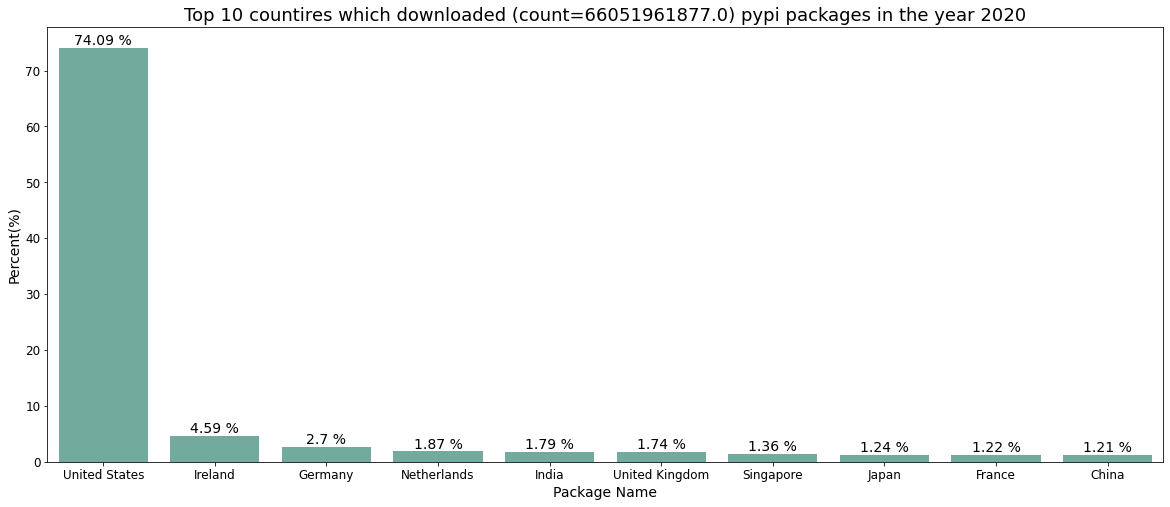

In [18]:
# Set the figure size
plt.figure(figsize=(20,8))
n=country_downloads['num_downloads'].sum()
# plot a bar chart
plot1 = sns.barplot(
    y="percent", 
    x="country_name", 
    data=country_downloads.iloc[0:10,:], 
    color='#69b3a2');
plot1.set_ylabel("Percent(%)",fontsize=14)
plot1.set_xlabel("Package Name",fontsize=14)
plot1.tick_params(labelsize=12)
plt.title(f'Top 10 countires which downloaded (count={n}) pypi packages in the year 2020',fontsize=18);
print_labels_v(plot1);
plt.savefig('top_10_countires.png')

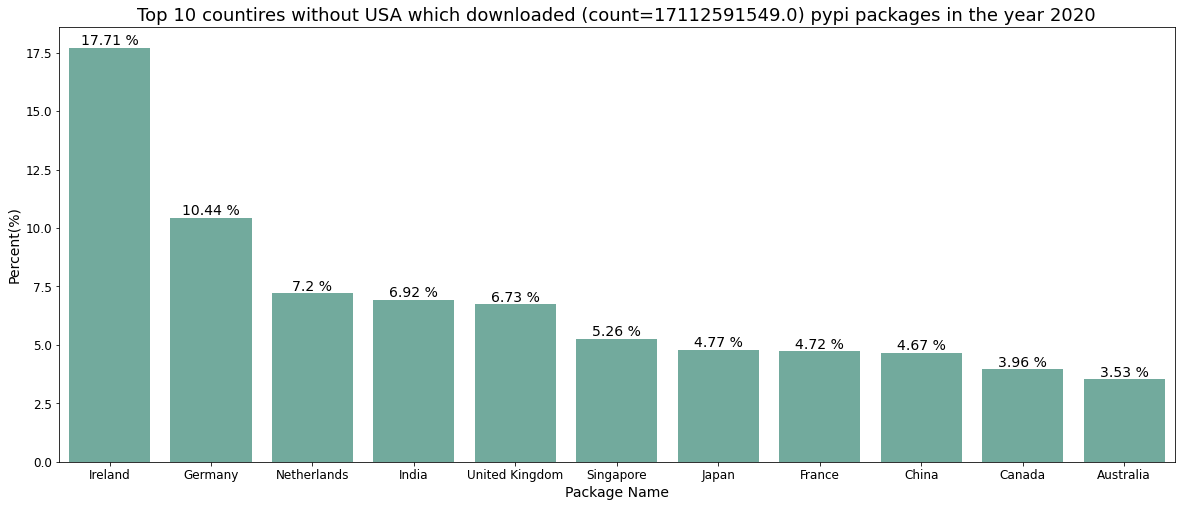

In [33]:
# Set the figure size
plt.figure(figsize=(20,8))
n1 = dwn_no_us['num_downloads'].sum()
# plot a bar chart
plot2 = sns.barplot(
    y="percent", 
    x="country_name", 
    data=dwn_no_us.iloc[0:11,:], 
    #estimator=sum, 
    #ci=None, 
    color='#69b3a2');

plot2.set_ylabel("Percent(%)",fontsize=14)
plot2.set_xlabel("Package Name",fontsize=14)
plot2.tick_params(labelsize=12)
plt.title(f'Top 10 countires without USA which downloaded (count={n1}) pypi packages in the year 2020',fontsize=18);
print_labels_v(plot2);
plt.savefig('top_10_countires_no_usa.png')

# Meta data EDA

In [20]:
meta_all = pd.read_csv('/project/class/sds_sdad/oss_capstone2021-2022/clean_data_11132021/pypi_meta_all.csv')

In [21]:
meta_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640255 entries, 0 to 20640254
Data columns (total 8 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   Unnamed: 0    int64 
 1   name          object
 2   version       object
 3   author        object
 4   author_email  object
 5   license       object
 6   home_page     object
 7   dependency    object
dtypes: int64(1), object(7)
memory usage: 1.2+ GB


In [22]:
meta = meta_all.drop(columns=['Unnamed: 0'])

In [23]:
meta.sample(10)

,name,version,author,author_email,license,home_page,dependency
5710083,RelStorage,2.1.1,Zope Foundation and Contributors,shane@willowrise.com,ZPL 2.1,http://relstorage.readthedocs.io/,zope.interface
17180029,ae-kivy-user-prefs,0.1.21,Andi Ecker,aecker2@gmail.com,OSI Approved :: GNU General Public License v3 ...,https://gitlab.com/ae-group/ae_kivy_user_prefs,coverage-badge ; extra == 'dev'
10659611,bio2bel-hgnc,0.3.0,Charles Tapley Hoyt,cthoyt@gmail.com,MIT License,https://github.com/bio2bel/hgnc,click
2907331,amundsen-search,2.5.1,NaN,NaN,NaN,https://github.com/amundsen-io/amundsensearchl...,flask-cors (==3.0.8)
9099959,ccxt,1.42.80,Igor Kroitor,igor.kroitor@gmail.com,MIT,https://ccxt.trade,flake8 (==3.7.9) ; extra == 'qa'
10807075,gsheetsdb,0.1.11,Beto Dealmeida,beto@dealmeida.net,MIT,https://github.com/betodealmeida/gsheets-db-api,six
7716997,pidan,1.0.9.23,chengang,chengang.net@gmail.com,UNKNOWN,UNKNOWN,NaN
15121465,rexmas-users-service,0.1.17,Admin,admin@example.com,NaN,NaN,"pylint (>=2.6.0,<3.0.0)"
13163071,cdk-remote-stack,0.1.63,Pahud Hsieh<hunhsieh@amazon.com>,NaN,Apache-2.0,https://github.com/pahud/cdk-remote-stack.git,"aws-cdk.aws-logs (<2.0.0,>=1.62.0)"
4588046,inforion,2.11.35,Daniel Jordan,daniel.jordan@fellow-consulting.de,NaN,https://github.com/Fellow-Consulting-AG/inforion/,progressbar (==2.5)


In [24]:
hp = meta[['name','home_page']]

In [25]:
hp = hp.loc[~hp.home_page.isna()]

In [26]:
n_pkg = len(hp.name.unique())

### Homepage Sites

In [41]:
homepage_host = meta['home_page'].str.split('/', n = 4, expand = True) #split the homepage column to determine the popular domains
homepage_host[2] = homepage_host[2].str.replace('www.', "") #remove www. from hosting site names
hosting_sites = pd.DataFrame(homepage_host[2].value_counts()) #count unique hosting sites 
hosting_sites = hosting_sites.rename(columns={2:'Projects Hosted'}) #rename column
hosting_sites[0:21] #display top twenty hosting sites 

,Projects Hosted
github.com,13487782
gitlab.com,342098
docs.openstack.org,241205
bitbucket.org,205853
perceptilabs.com,197941
ccxt.trade,139899
airflow.apache.org,104295
developer.cisco.com,86931
tensorflow.org,74742
pypi.python.org,67350


In [42]:
hosting_sites['percent'] = 100*(hosting_sites['Projects Hosted']/hosting_sites['Projects Hosted'].sum())
#hosting_sites = hosting_sites.reset_index()

In [43]:
hosting_sites

,Projects Hosted,percent
github.com,13487782,72.169923
gitlab.com,342098,1.830485
docs.openstack.org,241205,1.290631
bitbucket.org,205853,1.101471
perceptilabs.com,197941,1.059135
...,...,...
daodao.org,1,0.000005
digitaldevops.co.uk,1,0.000005
ndp-systemes.fr,1,0.000005
catonmat.net,1,0.000005


In [44]:
hosting_sites['Projects Hosted']#[3:].sum()

github.com             13487782
gitlab.com               342098
docs.openstack.org       241205
bitbucket.org            205853
perceptilabs.com         197941
                         ...   
daodao.org                    1
digitaldevops.co.uk           1
ndp-systemes.fr               1
catonmat.net                  1
recipy.org                    1
Name: Projects Hosted, Length: 21062, dtype: int64

In [45]:
#the top 3
hosting_sites_cp =hosting_sites.head(3)
hosting_sites_cp = hosting_sites_cp.reset_index()
new_row = pd.DataFrame(data = {
    'index' : ['others'],
    'Projects Hosted' : [hosting_sites['Projects Hosted'].iloc[3:].sum()],
    'percent' : [hosting_sites['percent'].iloc[3:].sum()]
})
hosting_sites_cp = pd.concat([hosting_sites_cp, new_row])

hosting_sites_cp = hosting_sites_cp.set_index('index')
hosting_sites_cp

,Projects Hosted,percent
index,,
github.com,13487782,72.169923
gitlab.com,342098,1.830485
docs.openstack.org,241205,1.290631
others,4617839,24.708961


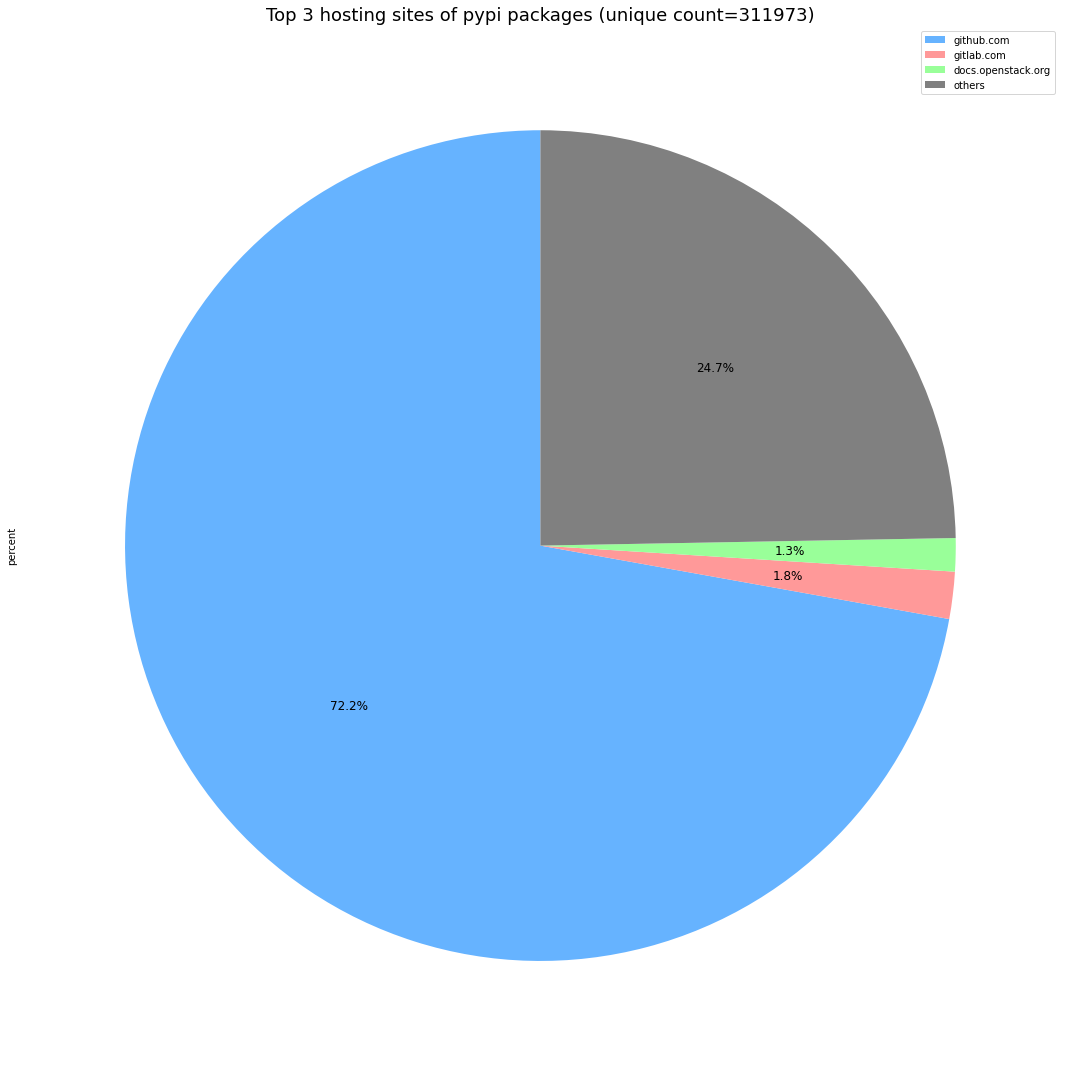

In [58]:
hosting_sites_cp = hosting_sites_cp.head(4)
colors = ['#66b3ff','#ff9999','#99ff99','#808080']
hosting_sites_cp.plot.pie(y='percent', labels=None,figsize=(15,15),autopct='%.1f%%',fontsize=12,colors = colors, startangle=90)
plt.title(f'Top 3 hosting sites of pypi packages (unique count={n_pkg})',fontsize=18);
plt.tight_layout()
plt.savefig('top_3_hostingsites.png')

### Number of Versions per Package

In [25]:
versions = meta[['name','version']]
versions_count = pd.DataFrame(versions.groupby('name').count())
versions_count = versions_count.reset_index()
versions_count = versions_count.sort_values(by='version',ascending=False)

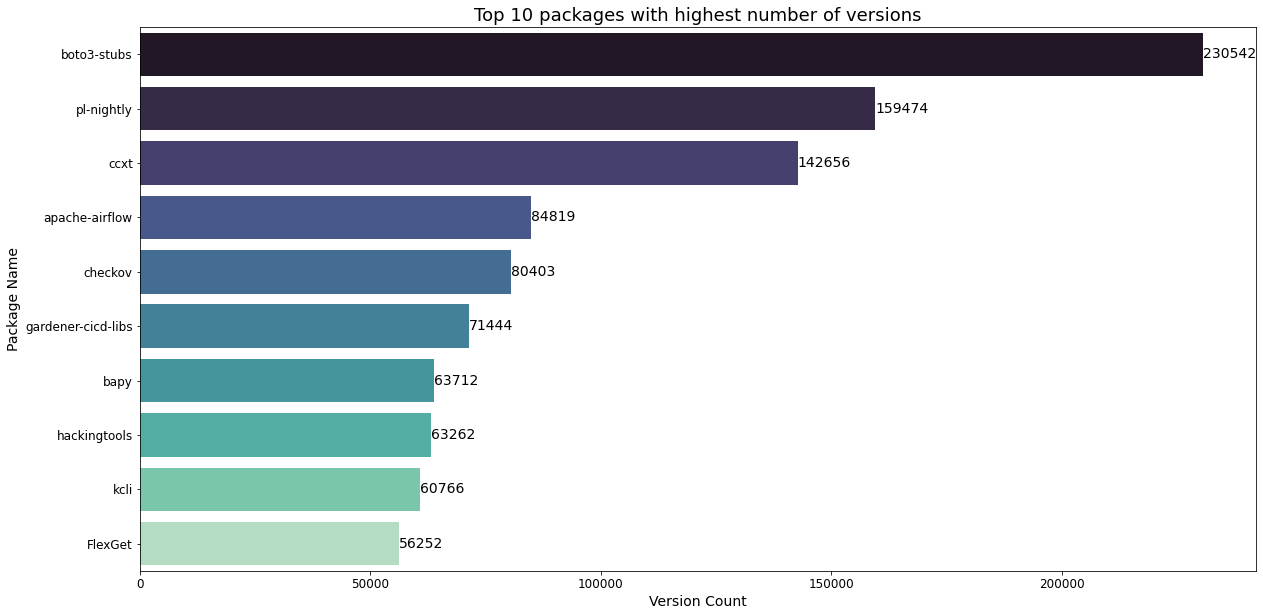

In [26]:
plt.figure(figsize=(20,10))
versions_count_10 = versions_count.head(10)
hv_bar = sns.barplot(x='version',y='name',data=versions_count_10,palette='mako')
print_labels_h(hv_bar)
hv_bar.set_ylabel("Package Name",fontsize=14)
hv_bar.set_xlabel("Version Count",fontsize=14)
hv_bar.tick_params(labelsize=12)
plt.title('Top 10 packages with highest number of versions',fontsize=18);
plt.savefig('top_10_versions.png')

In [47]:
dwnld_df

,name,version,num_downloads,country_name,Code
0,chardet,3.0.4,529606563,United States,US
1,python-dateutil,2.8.1,506601529,United States,US
2,six,1.15.0,425427437,United States,US
3,pyasn1,0.4.8,423882729,United States,US
4,s3transfer,0.3.3,413058876,United States,US
...,...,...,...,...,...
95,configparser,4.0.2,65728577,United States,US
96,py,1.9.0,65594032,United States,US
97,cryptography,2.8,65292734,United States,US
98,pip,20.2.4,65278294,United States,US


In [48]:
versions_downloads = dwnld_df.merge(versions_count, how='inner', left_on='name', right_on='name')
versions_downloads.head()

,name,version_x,num_downloads,country_name,Code,version_y
0,chardet,3.0.4,529606563,United States,US,24
1,python-dateutil,2.8.1,506601529,United States,US,57
2,six,1.15.0,425427437,United States,US,48
3,six,1.14.0,224275094,United States,US,48
4,pyasn1,0.4.8,423882729,United States,US,365


In [49]:
versions_downloads = versions_downloads.fillna(0)
versions_downloads = versions_downloads[versions_downloads["version_y"]>5]
versions_downloads = versions_downloads[versions_downloads["num_downloads"]>10000]
len(versions_downloads)

90

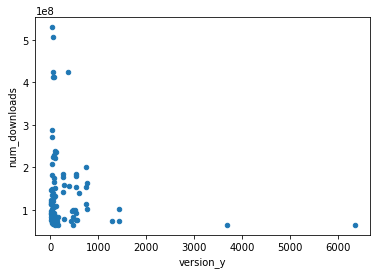

In [51]:
versions_downloads.plot.scatter('version_y', 'num_downloads');

In [52]:
package_counts = meta.groupby('name').count()
package_counts.head()

,version,author,author_email,license,home_page,dependency
name,,,,,,
0,1,1,1,1,0,0
0-core-client,10,10,10,10,10,9
0-orchestrator,36,36,36,36,36,36
0.0.1,1,1,1,1,1,0
0.0.5,6,6,6,6,6,6


In [57]:
meta.columns

Index(['name', 'version', 'author', 'author_email', 'license', 'home_page',
       'dependency'],
      dtype='object')

In [58]:
dependency_counts = meta.groupby('dependency').count()
dependency_counts.head()

,name,version,author,author_email,license,home_page
dependency,,,,,,
0,1,1,1,1,1,1
0-.-.-.-.-.-.-.-.-.-.-.-.-0,1,1,1,1,1,1
0-core-client,1,1,1,1,1,1
0-orchestrator,1,1,1,1,1,1
0.0.1,1,1,1,1,1,1


In [59]:
#dep_merge = package_counts.merge(dependency_counts, how='left', left_on='one_dep', right_on='name')
dc = dependency_counts['version'].to_dict()
pc = package_counts['version'].to_dict()

In [61]:
pac_deps = []
for pac in pc:
    if pac in dc:
        pac_deps.append([pc[pac], dc[pac]])
pac_deps_df = pd.DataFrame(pac_deps, columns=['package_counts','dependency_counts'])
pac_deps_df

,package_counts,dependency_counts
0,1,1
1,10,1
2,36,1
3,1,1
4,1,1
...,...,...
27488,604,99
27489,6,49
27490,28,31
27491,9,4


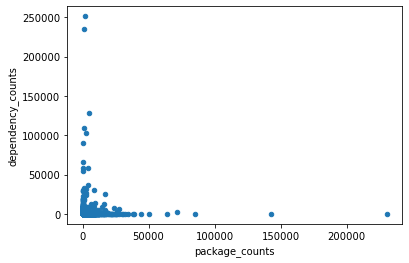

In [64]:
pac_deps_df.plot.scatter('package_counts', 'dependency_counts');

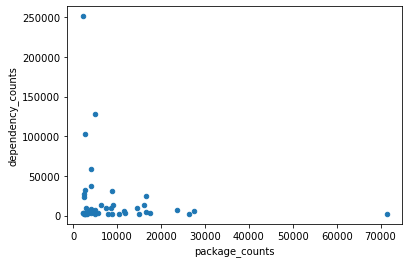

In [66]:
pac_deps_df= pac_deps_df[pac_deps_df['package_counts'] > 2000]
pac_deps_df = pac_deps_df[pac_deps_df['dependency_counts'] > 2000]
pac_deps_df.plot.scatter('package_counts', 'dependency_counts');

# Dependency Data

In [19]:
dep_df = pd.read_csv('/project/class/sds_sdad/oss_capstone2021-2022/clean_data_11132021/dependency_edgelist_112021.csv')
dep_df = dep_df.drop(columns=['Unnamed: 0'])
dep_df.sample(10)

,name,dependency_name
4543030,striemann,none
4833574,click-skeleton,click-option-group
16729327,micros,none
11638792,fancy-config,none
8487021,cfn-lint,six
6511561,cfs,none
19279997,SQLAlchemy,pg8000
19616592,d2b,pluggy
2270098,rft-core,pdfminer3k
14484981,odoo11-addons-oca-sale-workflow,odoo11-addon-sale-start-end-dates


In [20]:
npkg=len(dep_df.name.unique())
npkg

359786

In [21]:
dep_df_g = pd.DataFrame(dep_df.groupby('name')['dependency_name'].size())
dep_df_g = dep_df_g.reset_index()
dep_df_g.columns=['name','dep_count']
dep_df_g = dep_df_g.loc[dep_df_g['name']!='none'].sort_values(by='dep_count',ascending=False)
dep_df_g.head(10)

,name,dep_count
60881,boto3-stubs,230542
239958,pl-nightly,159474
67024,ccxt,142656
42475,apache-airflow,84819
69791,checkov,80403
140312,gardener-cicd-libs,71444
53724,bapy,63712
151686,hackingtools,63262
173802,kcli,60766
10130,FlexGet,56252


In [22]:
dep_df_stb = dep_df.loc[dep_df['dependency_name']!='none'].stb.freq(['dependency_name'])
dep_df_stb = dep_df_stb[['dependency_name','count','percent']].sort_values(by='percent',ascending=False)

In [23]:
dep_df_stb

,dependency_name,count,percent
0,numpy,564084,3.205974
1,requests,536537,3.049411
2,pandas,307460,1.747450
3,pytest,305525,1.736453
4,aws-cdk,296769,1.686688
...,...,...,...
50272,predictnow-client,1,0.000006
50273,precommit-message-preservation,1,0.000006
50274,pps-gui,1,0.000006
50275,ppqi,1,0.000006


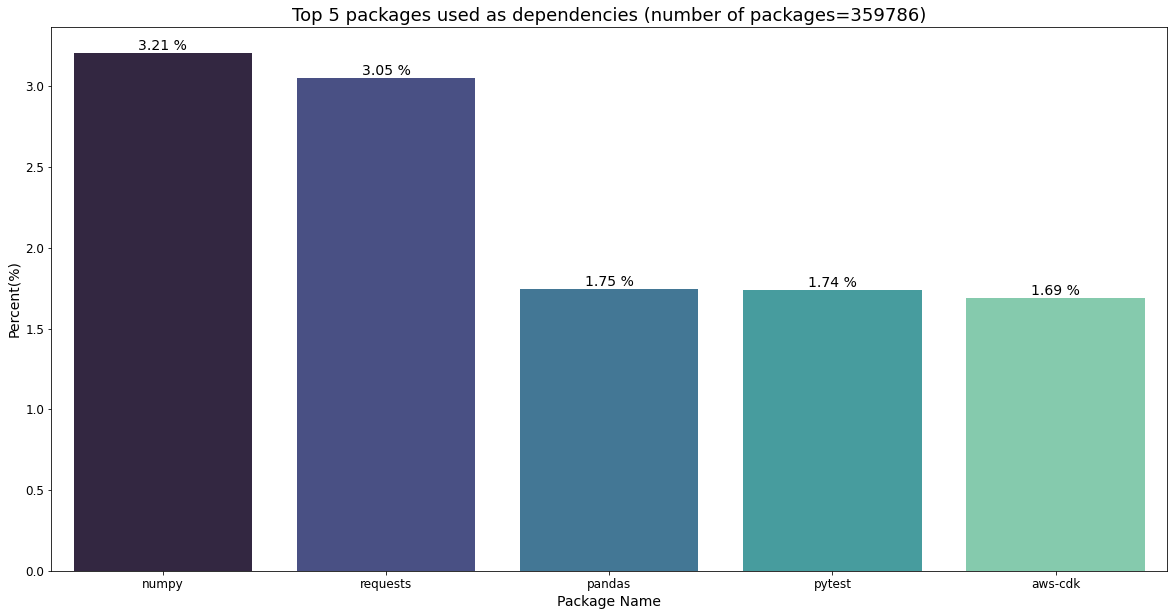

In [24]:
plt.figure(figsize=(20,10))
dep_df_stb_5 = dep_df_stb.head(5)
p1 = sns.barplot(y='percent',x='dependency_name',data=dep_df_stb_5,palette='mako');
p1.set_ylabel("Percent(%)",fontsize=14)
p1.set_xlabel("Package Name",fontsize=14)
p1.tick_params(labelsize=12)
plt.title(f'Top 5 packages used as dependencies (number of packages={npkg})',fontsize=18);
print_labels_v(p1);
plt.savefig('top_5_dep.png')

In [25]:
pkg_dep = dep_df.groupby(['name']).size()
pkg_dep = pkg_dep.reset_index()
pkg_dep = pkg_dep.sort_values(by=0, ascending=False)

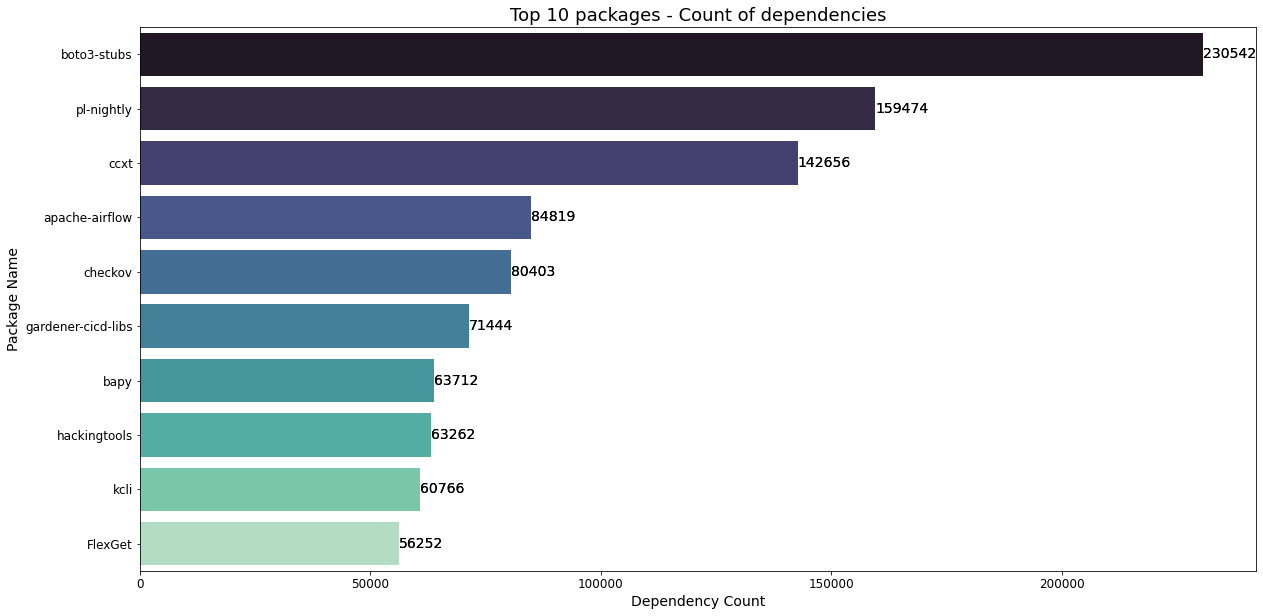

In [26]:
plt.figure(figsize=(20,10))
pkg_dep = pkg_dep.head(10)
h_bar = sns.barplot(x=0,y='name',data=pkg_dep,palette='mako')
for rect in h_bar.patches:
    ycoor = rect.get_y() + .5*rect.get_height()
    xcoor = rect.get_width()
    plt.text(xcoor, ycoor, str(int(xcoor)), 
             horizontalalignment='left', 
             verticalalignment='center',
             fontsize=14)
h_bar.set_ylabel("Package Name",fontsize=14)
h_bar.set_xlabel("Dependency Count",fontsize=14)
h_bar.tick_params(labelsize=12)
plt.title(f'Top 10 packages - Count of dependencies',fontsize=18);
print_labels_h(h_bar);
plt.savefig('top_10_usedep.png')

### Number of downloads vs dependecies

In [27]:
dwnld_df_sm = dwnld_df[dwnld_df["num_downloads"]>10000]
dep_df_stb_sm = dep_df_stb[dep_df_stb['count']>10000]

In [31]:
dep_df_stb

,dependency_name,count,percent
0,numpy,564084,3.205974
1,requests,536537,3.049411
2,pandas,307460,1.747450
3,pytest,305525,1.736453
4,aws-cdk,296769,1.686688
...,...,...,...
50272,predictnow-client,1,0.000006
50273,precommit-message-preservation,1,0.000006
50274,pps-gui,1,0.000006
50275,ppqi,1,0.000006


In [28]:
pkg_downloads = dwnld_df_sm.merge(dep_df_stb_sm, how='inner', left_on='name', right_on='dependency_name')
pkg_downloads = pkg_downloads.drop_duplicates()
pkg_downloads = pkg_downloads.drop(columns=['version','Code','dependency_name'])
pkg_downloads

,name,num_downloads,country_name,count,percent
0,chardet,529606563,United States,44910,0.255246
1,chardet,38565154,Ireland,44910,0.255246
2,chardet,23626303,Germany,44910,0.255246
3,chardet,18105431,United States,44910,0.255246
4,chardet,12733501,Singapore,44910,0.255246
...,...,...,...,...,...
53303,genie,12700,United States,14146,0.080399
53304,plone,13685,United States,29494,0.167629
53305,pyats,13675,United States,23726,0.134847
53306,pyats,12681,United States,23726,0.134847


In [48]:
pkg_downloads_g = pkg_downloads.groupby(['name'])[['num_downloads','count']].sum()
pkg_downloads_g = pkg_downloads_g.sort_values(by='count',ascending=False)
pkg_downloads_g = pkg_downloads_g.reset_index()

In [41]:
pkg_downloads_g

,name,num_downloads,count
0,urllib3,1261154663,60266294
1,six,1100456562,85949076
2,botocore,982636793,65433366
3,requests,904679139,349822124
4,setuptools,878280666,306547257
...,...,...,...
227,zope,154707,475560
228,dagster,112613,50334
229,genie,55462,56584
230,pyats,38883,71178


In [67]:
pkg_downloads_g.columns = ['package name','num_downloads', 'dependent count']
pkg_downloads_g.head(5)

,package name,num_downloads,dependent count
0,numpy,555314381,522905868
1,requests,904679139,349822124
2,boto3,606273292,331717545
3,setuptools,878280666,306547257
4,pytest,199683698,227921650


<Figure size 1440x1440 with 0 Axes>

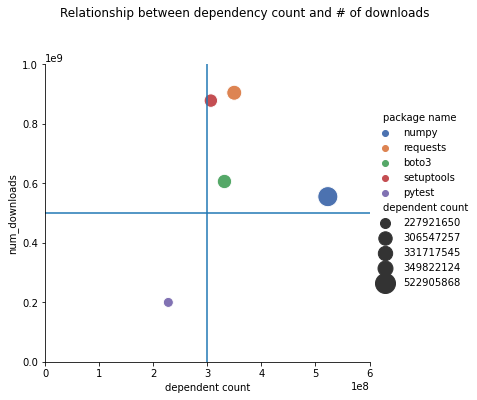

In [83]:
plt.figure(figsize=(20,20));
pl = sns.relplot(y="num_downloads", x="dependent count",hue='package name',size='dependent count',palette='deep', sizes=(100,400),
            data=pkg_downloads_g.head(5));
pl.set(xlim=(0,600000000));
pl.set(ylim=(0,1000000000))
plt.axvline(300000000);
plt.axhline(500000000);
plt.suptitle("Relationship between dependency count and # of downloads", y=1.1);
plt.savefig("scatter_rel.png");

# Contributor Data

In [67]:
from sqlalchemy import create_engine
import psycopg2
#https://stackoverflow.com/questions/40216311/reading-in-environment-variables-from-an-environment-file
from dotenv import load_dotenv
load_dotenv()
import touch
import time
pd.set_option('display.max_rows', 100000000000)

In [72]:
#making conenction to postgresSQL DB
pgpassword = os.getenv('password')
pguser = os.getenv('user')
host =  'postgis1-s.bii.virginia.edu'
database = 'sdad'
#port = 

#trying connection
dbserver_p = psycopg2.connect(
    user=pguser, 
    password=pgpassword, 
    host=host,
    database=database 
)

#dbserver_p.autocommit = True
cursor_p = dbserver_p.cursor()

engine_p = create_engine("postgresql+psycopg2://{user}:{pw}@{host}/{db}"
                       .format(user=pguser, pw=pgpassword, host=host, db=database))

In [78]:
query = """  
    select * 
    from gh.commits_pypi_112021 
"""
cont_df = pd.read_sql_query(query, con=engine_p)

In [79]:
cont_df.sample(10)

,slug,committed_date,login,additions,deletions
4301747,sfischer13/python-arpa,2018-12-12 13:58:58-05:00,sfischer13,7,4
899183,cms-sw/cmssw,2009-05-25 12:24:14-04:00,null,1,1
416350,bccp/nbodykit,2017-09-21 11:38:54-04:00,nickhand,268,118
2399624,jmathai/elodie,2016-09-07 23:51:57-04:00,jmathai,8,1
3842335,pypa/setuptools,2017-09-29 10:27:34-04:00,jaraco,12,4
4521432,stsewd/bookpy,2016-10-28 21:25:44-04:00,stsewd,2,0
109492,aioli-framework/aioli,2019-06-02 16:40:36-04:00,rbw,1,1
988070,cms-sw/cmssw,2012-06-06 03:31:56-04:00,null,1,1
3449892,onelogin/python-saml,2019-01-17 22:23:20-05:00,cclauss,1,1
1381363,drdoctr/doctr,2016-08-18 01:17:02-04:00,asmeurer,1,1
